# Imports

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import os
import json

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model
from Logits2Predictions import Logits2Predictions

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

idx = pd.IndexSlice

from config import Settings; settings = Settings()

# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Parameters

In [3]:
experiment_id = 'A'
# sanity check
experiment_folder = os.path.join(settings.data_base,settings.variational_data_folder,experiment_id)
assert os.path.exists(experiment_folder),f'Experiment {experiment_id} data doesn\'t exist. You can create it with <CreateVariationalOutputs.ipynb>'

## Compute variances

In [4]:
var_path = os.path.join(experiment_folder,'variational_forward.csv')
det_path = os.path.join(experiment_folder,'deterministic_forward.csv')
golden_path = os.path.join(experiment_folder,'golden.csv')

df_var = pd.read_csv(var_path,index_col=[0,1,2])
df_det = pd.read_csv(det_path,index_col=[0,1])
df_golden = pd.read_csv(golden_path,index_col=[0,1])

df_var.head(2)
df_var.shape

df_det.head(2)
df_det.shape

df_golden.head(2)
df_golden.shape

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index npass                                                     
21     1         1      0.001089  0.213134  0.096240  0.019529  0.000285   
                 2      0.001921  0.303439  0.127245  0.051660  0.001970   

                          diag_5    diag_6    diag_7    diag_8    diag_9  ...  \
pat_id adm_index npass                                                    ...   
21     1         1      0.002353  0.002609  0.002373  0.000421  0.002055  ...   
                 2      0.010256  0.003054  0.001259  0.000144  0.002890  ...   

                        diag_262  diag_263  diag_264  diag_265  diag_266  \
pat_id adm_index npass                                                     
21     1         1      0.000015  0.002675  0.000060  0.001814  0.085567   
                 2      0.000042  0.003102  0.000053  0.001158  0.093928   

                        diag_267  diag_268  diag_269  diag_270  diag_271  
pat_id adm_index npass                                                    
21     1         1      0.048912  0.000341  0.000403  0.000462  0.019775  
                 2      0.037497  0.000279  0.000206  0.000391  0.033320  

[2 rows x 272 columns]

(58290, 272)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.001347,0.305060,0.154384,0.039799,0.000894,0.005886,0.004791,0.001857,0.000335,0.003764,...,0.000047,0.002931,0.000098,0.003253,0.092871,0.054996,0.000995,0.000600,0.000669,0.030053
23,1,0.002962,0.074933,0.096509,0.014177,0.003340,0.005832,0.017698,0.000444,0.001100,0.004600,...,0.000206,0.001529,0.001064,0.001978,0.161321,0.075045,0.001475,0.000521,0.010034,0.027507


(1943, 272)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(1943, 272)

In [5]:
df_var_predictions = df_var.groupby(['pat_id','adm_index']).mean()
df_var_predictions.head(2)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.003643,0.278843,0.131898,0.038335,0.002025,0.009463,0.003971,0.003210,0.000279,0.003060,...,0.000031,0.002322,0.000065,0.002423,0.098382,0.054674,0.000506,0.000368,0.000398,0.026452
23,1,0.003327,0.091452,0.099650,0.017290,0.003665,0.008062,0.016247,0.000851,0.001052,0.004638,...,0.000238,0.001731,0.000882,0.002057,0.170441,0.072379,0.001680,0.000797,0.009854,0.030086


In [6]:
#common diagnoses
df_golden.sum().sort_values(ascending=False)

diag_95     758.0
diag_85     710.0
diag_93     691.0
diag_54     680.0
diag_88     663.0
            ...  
diag_163      0.0
diag_242      0.0
diag_162      0.0
diag_157      0.0
diag_155      0.0
Length: 272, dtype: float64

### Ideal threshold for each diagnosis

In [7]:
from sklearn.metrics import roc_curve
import warnings

def get_prediction_thresholds(prediction_data : pd.DataFrame, golden_data : pd.DataFrame, method='roc gm'):
    
    if method not in ['roc gm']:
        assert ValueError('method not supported')
    
    thresholds_data = None
    for diag in prediction_data.filter(like='diag_').columns:
        testy = golden_data.loc[:,diag].to_numpy().reshape((-1,1))
        yhat = prediction_data.loc[:,diag].to_numpy().reshape((-1,1))

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")
            fpr, tpr, thresholds = roc_curve(testy, yhat);

        #geometric mean between sensitivity and specificity
        gmeans = np.sqrt(tpr * (1-fpr))

        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)

        threshold = pd.DataFrame(data=[[thresholds[ix],gmeans[ix]]],columns=['threshold','gmean (roc)'],index=[diag])

        if thresholds_data is None:
            thresholds_data = threshold
        else:
            thresholds_data = pd.concat([thresholds_data,threshold])
    return thresholds_data

thresholds = get_prediction_thresholds(df_var_predictions,df_golden)
thresholds

,threshold,gmean (roc)
diag_0,0.003121,0.663023
diag_1,0.208381,0.637230
diag_2,0.120618,0.614190
diag_3,0.039007,0.616249
diag_4,0.600658,0.999477
...,...,...
diag_267,0.093406,0.607268
diag_268,0.004640,0.743348
diag_269,0.001596,0.817758
diag_270,0.009865,0.588097


# Accuracy as a function of confidence

In [8]:
def predict(predictions: pd.Series, threshold : float):
    return predictions.apply(lambda x: 1 if x > threshold else 0)

predictions = df_var_predictions.apply(lambda x: predict(x,thresholds.loc[x.name,'threshold']),axis=0)

predictions.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,1,1,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
23,1,1,0,0,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,1
61,1,1,1,0,1,0,0,1,0,1,0,...,1,0,0,0,1,1,0,0,0,1


## ECE 

reliability diagrams for all diagnostics

In [79]:
predictions = predictions
confidences_positive_class = df_var_predictions
confidences_predicted_class = df_var_predictions.where(predictions==1, 1-df_var_predictions)
accuracies = predictions == df_golden.to_numpy()

nbins = 10
bins = np.linspace(0,1,nbins+1)
bins_left = bins[:-1]
bins_right = bins[1:]

acc_in_bin_list = list()
perc_samples_in_bin_list = list() # percentage of samples in bin

for left,right in zip(bins_left,bins_right):
    
    # calculations from positive class
    in_bin = (confidences_positive_class > left) & (confidences_positive_class < right)
    perc_samples_in_bin_list.append(in_bin.mean())
    
    # calculations from  predicted class
    in_bin = (proba_predicted_class > left) & (proba_predicted_class < right)
    acc_in_bin_list.append(accuracies[in_bin].mean()) # accuracy in bin

## Save!

In [92]:
acc_in_bin = pd.DataFrame(acc_in_bin_list).fillna(0)
acc_in_bin.index.name = 'bins'
acc_in_bin.head(1)

perc_samples_in_bin = pd.DataFrame(perc_samples_in_bin_list).fillna(0)
perc_samples_in_bin.index.name = 'bins'
perc_samples_in_bin.head(1)

,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
bins,,,,,,,,,,,,,,,,,,,,,
0,0.005217,0.0,0.0,0.072,0.0,0.07767,0.036822,0.022663,0.0,0.030682,...,0.0,0.020619,0.027778,0.011577,0.0,0.137615,0.034803,0.001555,0.016129,0.019943


,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
bins,,,,,,,,,,,,,,,,,,,,,
0,0.998456,0.182192,0.414822,0.956768,0.975811,0.905301,0.991251,0.983016,1.0,0.992795,...,1.0,0.994853,1.0,0.999485,0.239321,0.656202,0.996397,0.999485,1.0,0.987133


In [97]:
def plot_reliabilityDF(acc, perc_samples=None):
    
    conf = np.linspace(0,1,nbins+1)[:-1]+0.05
    
    if perc_samples is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3));

        ax.plot([0,1], [0,1], 'k--') ;
        ax.bar(conf, acc,width=0.1);
        ax.set_xticks((np.arange(0, 1.1, step=0.2)));
        ax.set_ylabel(r'accuracy');
        ax.set_xlabel(r'confidence');
        ax.set_xticks((np.arange(0, 1.1, step=0.2)));
        ax.set_yticks((np.arange(0, 1.1, step=0.2)));
    
    else:
        fig, ax = plt.subplots(2, 1, figsize=(6, 6),subplot_kw={'aspect': 1});
        
        
        ax[0].bar(conf, perc_samples,width=0.1);
        ax[0].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[0].set_ylabel(r'% samples');
        #ax[0].set_xlabel(r'confidence');
        ax[0].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[0].set_yticks((np.arange(0, 1.1, step=0.2)));
        
        ax[1].plot([0,1], [0,1], 'k--',label='perfect calibration') ;
        ax[1].plot(conf, acc,marker='.');
        ax[1].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[1].set_ylabel(r'accuracy');
        ax[1].set_xlabel(r'confidence');
        ax[1].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[1].set_yticks((np.arange(0, 1.1, step=0.2)));
        ax[1].legend()
        
        fig.tight_layout(pad=1.0)

    return fig, ax

In [103]:
def plot_reliability(acc, conf,perc_samples=None):
    
    if perc_samples is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3));

        ax.plot([0,1], [0,1], 'k--') ;
        ax.bar(conf, acc,width=0.1);
        ax.set_xticks((np.arange(0, 1.1, step=0.2)));
        ax.set_ylabel(r'accuracy');
        ax.set_xlabel(r'confidence');
        ax.set_xticks((np.arange(0, 1.1, step=0.2)));
        ax.set_yticks((np.arange(0, 1.1, step=0.2)));
    
    else:
        fig, ax = plt.subplots(2, 1, figsize=(6, 6),subplot_kw={'aspect': 1});
        
        
        ax[0].bar(conf, perc_samples,width=0.1);
        ax[0].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[0].set_ylabel(r'% samples');
        #ax[0].set_xlabel(r'confidence');
        ax[0].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[0].set_yticks((np.arange(0, 1.1, step=0.2)));
        
        ax[1].plot([0,1], [0,1], 'k--',label='perfect calibration') ;
        ax[1].plot(conf, acc,marker='.');
        ax[1].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[1].set_ylabel(r'accuracy');
        ax[1].set_xlabel(r'confidence');
        ax[1].set_xticks((np.arange(0, 1.1, step=0.2)));
        ax[1].set_yticks((np.arange(0, 1.1, step=0.2)));
        ax[1].legend();
        
        fig.tight_layout(pad=1.0);

    return fig, ax

diag_221
diag_120
diag_246
diag_101
diag_5


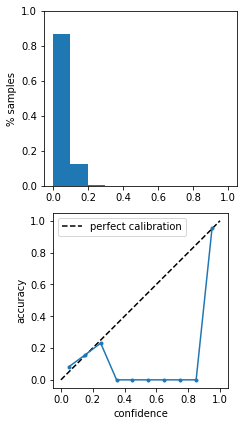

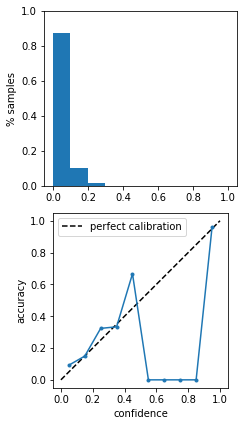

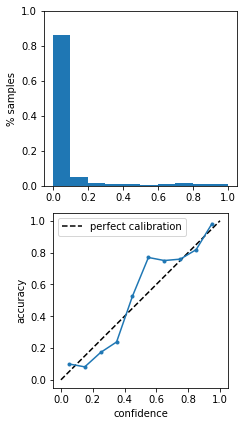

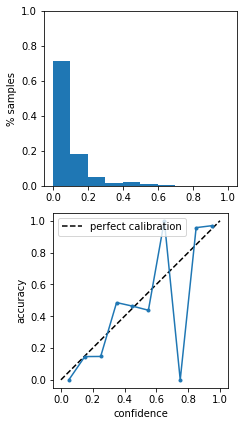

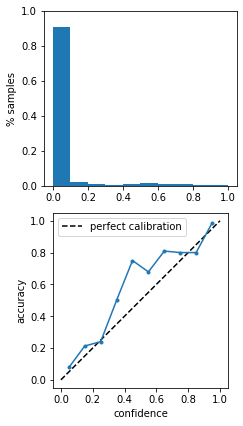

In [114]:
#common diagnoses
common = df_golden.sum().sort_values(ascending=False)

for diag in common.index[50:55]:
    print(diag)
    _ = plot_reliabilityDF(acc_in_bin[diag],perc_samples_in_bin[diag]);

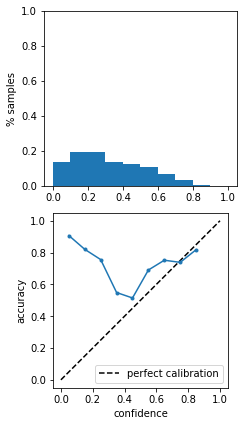

In [152]:
diag_accuracies = [e['diag_85'] for e in acc_in_bin_list]
diag_percentage = [e['diag_85'] for e in perc_samples_in_bin_list]

plot_reliability(diag_accuracies,x_axis,diag_percentage);

In [ ]:
output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )[['negative_class','positive_class']]

#predictions = np.argmax(output_probabilities.to_numpy(),axis=1) # not quite since it depends on the threshold
predictions = diagnostic_preds.to_numpy()
#confidences = np.max(output_probabilities.to_numpy(),axis=1)
confidences = 
accuracies = predictions == diagnostic_goldens.to_numpy()

nbins = 10
bins = np.linspace(0,1,nbins+1)
bins_left = bins[:-1]
bins_right = bins[1:]

for left,right in zip(bins_left,bins_right):
    in_bin = (confidences > left) & (confidences < right)
    in_bin.sum()

predictions = np.argmax(output_probabilities.to_numpy(),axis=1)
for left,right in zip(bins_left,bins_right):
    in_bin = (confidences > left) & (confidences < right)
    in_bin.sum()